In [3]:
import torch
from torch import nn
from torch_geometric.utils import subgraph
from graphxai.gnn_models.node_classification import GCN_2layer
import logging

# Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("GraphXAI-EdgeClassification")

# Load dataset
data = torch.load('processed_data.pt')
logger.info("Dataset loaded.")

# Get original edge_index and labels (truncate to 20k)
edge_index = data['user', 'item'].edge_index[:, :20000]
edge_label = data['user', 'item'].behavior[:20000]

# Offset item indices
offset = data['user'].num_nodes
edge_index[1] += offset

# Generate dummy features: one-hot only for sampled nodes
all_nodes = torch.unique(edge_index)
node_id_map = {nid.item(): i for i, nid in enumerate(all_nodes)}
mapped_edge_index = torch.tensor([
    [node_id_map[src.item()] for src in edge_index[0]],
    [node_id_map[dst.item()] for dst in edge_index[1]]
])

x = torch.eye(len(all_nodes))  # one-hot for only the subgraph
y = edge_label

logger.info(f"Sampled edges: {mapped_edge_index.shape[1]}")
logger.info(f"Unique nodes: {x.shape[0]}")


INFO:GraphXAI-EdgeClassification:Dataset loaded.
INFO:GraphXAI-EdgeClassification:Sampled edges: 20000
INFO:GraphXAI-EdgeClassification:Unique nodes: 14679


In [4]:
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn.functional as F

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
# Misalnya x.shape[1] = 64 fitur input, hidden 32, output 4 class
model = GCN_2layer(32, x.shape[1], 4).to(device)

x = x.to(device)
mapped_edge_index = mapped_edge_index.to(device)
y = y.to(device)

# Hitung class weight secara otomatis
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(edge_label.cpu().numpy()),
    y=edge_label.cpu().numpy()
)

# Ubah ke tensor dan pindahkan ke device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Gunakan di loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
model.train()
for epoch in range(1,31):
    optimizer.zero_grad()
    node_out = model(x, mapped_edge_index)
    src, dst = mapped_edge_index
    edge_feat = torch.cat([node_out[src], node_out[dst]], dim=1)
    edge_out = nn.Linear(edge_feat.shape[1], 4).to(device)(edge_feat)
    loss = criterion(edge_out, y)
    loss.backward()
    optimizer.step()
    logger.info(f"Epoch {epoch}, Loss: {loss.item():.4f}")

if epoch % 5 == 0:
    pred = edge_out.argmax(dim=1).detach().cpu().numpy()
    true = y.cpu().numpy()
    print(classification_report(true, pred))


INFO:GraphXAI-EdgeClassification:Epoch 1, Loss: 1.5776
INFO:GraphXAI-EdgeClassification:Epoch 2, Loss: 1.5080
INFO:GraphXAI-EdgeClassification:Epoch 3, Loss: 1.5895
INFO:GraphXAI-EdgeClassification:Epoch 4, Loss: 1.4216
INFO:GraphXAI-EdgeClassification:Epoch 5, Loss: 1.4931
INFO:GraphXAI-EdgeClassification:Epoch 6, Loss: 1.5907
INFO:GraphXAI-EdgeClassification:Epoch 7, Loss: 1.3552
INFO:GraphXAI-EdgeClassification:Epoch 8, Loss: 1.4333
INFO:GraphXAI-EdgeClassification:Epoch 9, Loss: 1.3886
INFO:GraphXAI-EdgeClassification:Epoch 10, Loss: 1.4315
INFO:GraphXAI-EdgeClassification:Epoch 11, Loss: 1.4100
INFO:GraphXAI-EdgeClassification:Epoch 12, Loss: 1.3657
INFO:GraphXAI-EdgeClassification:Epoch 13, Loss: 1.4227
INFO:GraphXAI-EdgeClassification:Epoch 14, Loss: 1.4348
INFO:GraphXAI-EdgeClassification:Epoch 15, Loss: 1.5300
INFO:GraphXAI-EdgeClassification:Epoch 16, Loss: 1.3882
INFO:GraphXAI-EdgeClassification:Epoch 17, Loss: 1.4936
INFO:GraphXAI-EdgeClassification:Epoch 18, Loss: 1.4824
I

              precision    recall  f1-score   support

           0       0.92      0.53      0.67     18035
           1       0.00      0.00      0.00      1036
           2       0.02      0.24      0.04       451
           3       0.02      0.18      0.03       478

    accuracy                           0.49     20000
   macro avg       0.24      0.24      0.19     20000
weighted avg       0.83      0.49      0.61     20000



In [5]:
import numpy as np
unique, counts = np.unique(edge_label.cpu().numpy(), return_counts=True)
print(dict(zip(unique, counts)))

# 0 = click, 1 = add to cart, 2 = buy, 3 = add to favorite

{0: 18035, 1: 1036, 2: 451, 3: 478}


INFO:EdgeClassification:Loading processed_data.pt...
INFO:EdgeClassification:Dataset loaded successfully.


Subset size: 100000 edges
Edge index: tensor([[  48491,   48491,   48491,  ...,    8421,    8421,    8421],
        [ 463421,  182135, 1060760,  ...,  374312,  784605,    7067]])
Edge label: tensor([0, 0, 0,  ..., 0, 0, 0])


INFO:EdgeClassification:Total nodes: 1148489
INFO:EdgeClassification:User nodes: 49400
INFO:EdgeClassification:Item nodes: 1099089
INFO:EdgeClassification:Edge count (subset): 100000
INFO:EdgeClassification:Feature dimension: 32
INFO:EdgeClassification:Number of behavior classes: 4
INFO:EdgeClassification:Model initialized with 4 output classes.
INFO:EdgeClassification:Using balanced class weights: [ 0.27963582  4.5695486  11.51543     8.457375  ]
INFO:EdgeClassification:Starting training...
INFO:EdgeClassification:Epoch 10, Loss: 1.3766


Classification Report (Epoch 10):
              precision    recall  f1-score   support

           0       0.91      0.26      0.40     89402
           1       0.06      0.24      0.09      5471
           2       0.03      0.45      0.06      2171
           3       0.04      0.29      0.07      2956

    accuracy                           0.26    100000
   macro avg       0.26      0.31      0.16    100000
weighted avg       0.82      0.26      0.37    100000



INFO:EdgeClassification:Epoch 20, Loss: 1.3629


Classification Report (Epoch 20):
              precision    recall  f1-score   support

           0       0.92      0.26      0.40     89402
           1       0.06      0.26      0.10      5471
           2       0.04      0.54      0.07      2171
           3       0.05      0.30      0.08      2956

    accuracy                           0.26    100000
   macro avg       0.27      0.34      0.16    100000
weighted avg       0.83      0.26      0.37    100000



INFO:EdgeClassification:Epoch 30, Loss: 1.3469


Classification Report (Epoch 30):
              precision    recall  f1-score   support

           0       0.92      0.32      0.48     89402
           1       0.07      0.28      0.11      5471
           2       0.04      0.49      0.07      2171
           3       0.05      0.34      0.09      2956

    accuracy                           0.33    100000
   macro avg       0.27      0.36      0.19    100000
weighted avg       0.83      0.33      0.44    100000



INFO:EdgeClassification:Epoch 40, Loss: 1.3267


Classification Report (Epoch 40):
              precision    recall  f1-score   support

           0       0.93      0.36      0.51     89402
           1       0.07      0.30      0.12      5471
           2       0.04      0.45      0.08      2171
           3       0.06      0.41      0.10      2956

    accuracy                           0.36    100000
   macro avg       0.28      0.38      0.20    100000
weighted avg       0.83      0.36      0.47    100000



INFO:EdgeClassification:Epoch 50, Loss: 1.3031
INFO:EdgeClassification:Training finished.
INFO:EdgeClassification:Starting explanation generation using GraphLIME...
INFO:EdgeClassification:Selected edge for explanation: User 28 -> Item 49405
INFO:EdgeClassification:Subgraph extracted: 2 nodes, 0 edges
INFO:EdgeClassification:No connecting edges found in the subgraph. Adding a dummy edge between the target nodes.
INFO:EdgeClassification:Using node 0 (remapped from user 28) as target for explanation.
/home/mlpc2/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:116: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
INFO:EdgeClassification:Explanation generated using GraphLIME.


Classification Report (Epoch 50):
              precision    recall  f1-score   support

           0       0.93      0.35      0.51     89402
           1       0.08      0.31      0.12      5471
           2       0.05      0.45      0.08      2171
           3       0.06      0.47      0.11      2956

    accuracy                           0.36    100000
   macro avg       0.28      0.40      0.21    100000
weighted avg       0.84      0.36      0.47    100000

sub_nodes: tensor([   28, 49405], device='cuda:0')
sub_edge_index: tensor([], device='cuda:0', size=(2, 0), dtype=torch.int64)


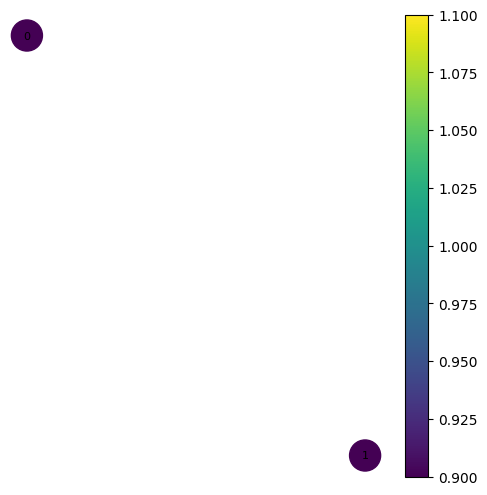

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import logging
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.nn import GCNConv
from torch_geometric.utils import k_hop_subgraph, to_networkx
from torch_geometric.data import Data
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from graphxai.explainers import GraphLIME

# -------------------- PART 1: DATA LOADING & PREPARATION --------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("EdgeClassification")

logger.info("Loading processed_data.pt...")
try:
    data = torch.load('processed_data.pt')
    logger.info("Dataset loaded successfully.")
except FileNotFoundError:
    logger.error("Error: processed_data.pt not found. Please ensure the file is in the correct directory.")
    exit()

# Use a subset of edges for efficiency (use up to 20,000 edges)
num_available_edges = data['user', 'item'].edge_index.shape[1]
subset_size = min(100_000, num_available_edges)
edge_index = data['user', 'item'].edge_index[:, :subset_size]
edge_label = data['user', 'item'].behavior[:subset_size]
print(f"Subset size: {subset_size} edges")
print(f"Edge index: {edge_index}")
print(f"Edge label: {edge_label}")
# Offset item indices globally (users first, then items)
num_users = data['user'].num_nodes
edge_index[1] += num_users

# Create dummy features (random embeddings)
num_items = data['item'].num_nodes
num_nodes = num_users + num_items
embedding_dim = 32
x = torch.randn((num_nodes, embedding_dim))

# Our task is edge classification; ensure labels are long integers.
y = edge_label.long()

logger.info(f"Total nodes: {num_nodes}")
logger.info(f"User nodes: {num_users}")
logger.info(f"Item nodes: {num_items}")
logger.info(f"Edge count (subset): {edge_index.shape[1]}")
logger.info(f"Feature dimension: {embedding_dim}")
logger.info(f"Number of behavior classes: {len(torch.unique(y))}")

# -------------------- PART 2: MODEL DEFINITION --------------------
class GCN_2layer(nn.Module):
    def __init__(self, hidden_channels, input_feat, num_classes):
        super().__init__()
        self.conv1 = GCNConv(input_feat, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, num_classes)
        )
        
    def forward(self, x, edge_index, edge_label_index):
        # Compute node embeddings
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        # Concatenate embeddings for endpoints and predict edge class
        src, dst = edge_label_index
        edge_feat = torch.cat([x[src], x[dst]], dim=1)
        return self.edge_mlp(edge_feat)
    
    # Helper method to return node embeddings (for node-level explanation)
    def get_node_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
edge_index = edge_index.to(device)
y = y.to(device)
# For edge classification, we use the same edge_index as the label indices.
edge_label_index = edge_index

# Ensure number of classes is set correctly.
num_classes = int(y.max().item() + 1)
if num_classes <= 1:
    logger.warning(f"Only {num_classes} class found. Using at least 2 classes for CrossEntropyLoss.")
    num_classes = 2

model = GCN_2layer(32, x.shape[1], num_classes).to(device)
logger.info(f"Model initialized with {num_classes} output classes.")

# Compute balanced class weights if more than one class is present.
y_np = y.cpu().numpy()
unique_classes = np.unique(y_np)
if len(unique_classes) > 1:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_np
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    logger.info(f"Using balanced class weights: {class_weights_tensor.cpu().numpy()}")
else:
    logger.warning("Only one class in labels; using default CrossEntropyLoss.")
    criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -------------------- PART 3: TRAINING --------------------
logger.info("Starting training...")
model.train()
num_epochs = 50
for epoch in range(1, num_epochs+1):
    optimizer.zero_grad()
    out = model(x, edge_index, edge_index)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        logger.info(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        pred = out.argmax(dim=1).detach().cpu().numpy()
        true = y.cpu().numpy()
        print(f"Classification Report (Epoch {epoch}):")
        print(classification_report(true, pred, zero_division=0))

logger.info("Training finished.")

# -------------------- PART 4: EXPLANATION & SUBGRAPH EXTRACTION --------------------
logger.info("Starting explanation generation using GraphLIME...")

# Choose a target user–item pair for our question "Will user X buy item Y?"
# (Ensure user_x is within [0, num_users-1] and item_y is within [num_users, num_nodes-1])
user_x = 28
item_y_local = 5  # e.g. 6th item among items
item_y = num_users + item_y_local
logger.info(f"Selected edge for explanation: User {user_x} -> Item {item_y}")

# To capture more connectivity, extract a 3-hop subgraph around these nodes.
sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx=[user_x, item_y],
    num_hops=5,
    edge_index=edge_index,
    relabel_nodes=True,
    num_nodes=x.shape[0]
)
logger.info(f"Subgraph extracted: {len(sub_nodes)} nodes, {sub_edge_index.shape[1]} edges")
print("sub_nodes:", sub_nodes)
print("sub_edge_index:", sub_edge_index)

# Create a PyG Data object for the subgraph.
sub_data = Data(x=x[sub_nodes], edge_index=sub_edge_index)
# Add a 'nodes' attribute required for visualization.
sub_data.nodes = list(range(sub_data.num_nodes))

# (Optional) If no connecting edges exist in the extracted subgraph, add a dummy edge.
if sub_data.edge_index.numel() == 0:
    logger.info("No connecting edges found in the subgraph. Adding a dummy edge between the target nodes.")
    sub_data.edge_index = torch.tensor([[0], [1]], dtype=torch.long, device=device)

# Since GraphLIME explains nodes, choose one of the target nodes to explain.
# Here we explain the user node. The remapped index for user_x is taken from the mapping.
node_target = mapping[0].item()
logger.info(f"Using node {node_target} (remapped from user {user_x}) as target for explanation.")

# GraphLIME requires a label tensor for the nodes.
# Since we are not performing node classification, we supply a dummy 2D label tensor.
dummy_y = torch.zeros((sub_data.num_nodes, 1), dtype=torch.float32).to(device)

# Initialize GraphLIME explainer and get the explanation for the target node.
explainer = GraphLIME(model=model)
exp = explainer.get_explanation_node(
    node_idx=node_target,
    x=sub_data.x,
    edge_index=sub_data.edge_index,
    forward_kwargs={'edge_label_index': sub_data.edge_index},
    y=dummy_y
)
logger.info("Explanation generated using GraphLIME.")

# Set the explanation’s subgraph to our sub_data.
exp.enc_subgraph = sub_data

# -------------------- PART 5: CUSTOM VISUALIZATION FUNCTION --------------------
def custom_visualize_explanation(exp, ax=None, show=True):
    """
    Custom visualization:
      - Convert exp.enc_subgraph (a PyG Data object) to an undirected NetworkX graph.
      - Color nodes according to explanation importance (if available; else uniform).
      - Draw using a spring layout.
    """
    # Convert subgraph to NetworkX graph.
    G = to_networkx(exp.enc_subgraph, to_undirected=True)
    # Create an identity mapping from nodes in sub_data.
    node_map = {n: n for n in exp.enc_subgraph.nodes}
    
    # Try to retrieve node importance scores from the explanation.
    try:
        # exp.node_imp should be a tensor of shape (num_nodes_in_subgraph, ...)
        importance = exp.node_imp.detach().cpu().numpy().flatten()
    except Exception:
        importance = np.ones(len(G.nodes()))
    
    # Map importance to each node.
    node_colors = []
    for n in G.nodes():
        if n < len(importance):
            node_colors.append(importance[n])
        else:
            node_colors.append(0.0)
    
    # Normalize importance values.
    norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    cmap = plt.get_cmap("viridis")
    colors = [cmap(norm(val)) for val in node_colors]
    
    # Compute a spring layout.
    pos = nx.spring_layout(G, seed=42)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_color=colors, ax=ax, node_size=500, font_size=8)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax)
    if show:
        plt.show()

# -------------------- PART 6: VISUALIZE THE EXPLANATION --------------------
custom_visualize_explanation(exp, show=True)

In [65]:
# Assume user_x and item_y are defined (note: item_y is the global index after offset)
target_edge_exists = ((edge_index[0] == user_x) & (edge_index[1] == item_y)).sum() > 0
print("Target edge exists in subset:", target_edge_exists.item())

Target edge exists in subset: False


INFO:Case2_ItemInfluence:Loading processed_data.pt...
INFO:Case2_ItemInfluence:Dataset loaded successfully.
INFO:Case2_ItemInfluence:Using a subset of 100000 user-item edges.
INFO:Case2_ItemInfluence:Number of active users in subset: 974
INFO:Case2_ItemInfluence:User 61 has 89 interactions.
INFO:Case2_ItemInfluence:User 64 has 76 interactions.
INFO:Case2_ItemInfluence:User 67 has 33 interactions.
INFO:Case2_ItemInfluence:User 68 has 101 interactions.
INFO:Case2_ItemInfluence:User 73 has 59 interactions.
INFO:Case2_ItemInfluence:Selected target user: 49239 (highest count: 607)
INFO:Case2_ItemInfluence:Extracted subgraph: 1 nodes, 0 edges


Subgraph nodes: tensor([49239], device='cuda:0')


Explain node 0: 100%|██████████| 100/100 [00:00<00:00, 179.49it/s]
INFO:Case2_ItemInfluence:GNNExplainer finished for target user node.


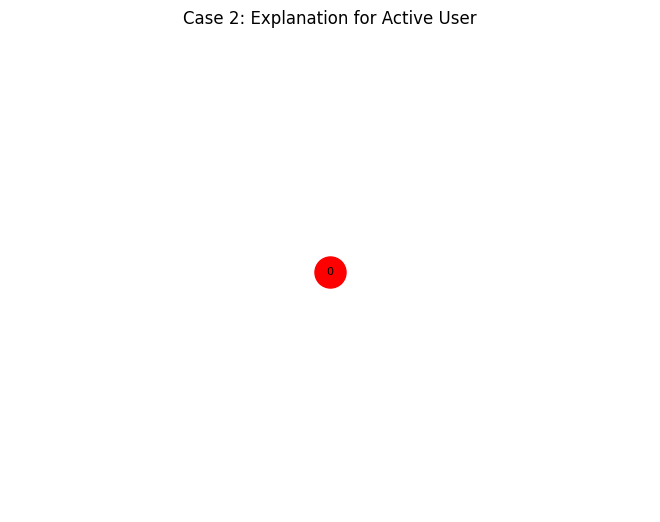

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GNNExplainer
from torch_geometric.utils import k_hop_subgraph, to_networkx
from torch_geometric.data import Data
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import logging
import matplotlib.pyplot as plt
import networkx as nx

# -------------------- PART 1: DATA LOADING & PREPARATION --------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("Case2_ItemInfluence")

logger.info("Loading processed_data.pt...")
try:
    proc_data = torch.load('processed_data.pt')
    logger.info("Dataset loaded successfully.")
except FileNotFoundError:
    logger.error("processed_data.pt not found. Please ensure the file is in the correct directory.")
    exit()

# We assume that proc_data is a HeteroData object.
# We use the user-item edge for our graph.
# In the processing script, items have not been offset,
# so we do the offset here:
user_item_edge_index = proc_data['user', 'item'].edge_index.clone()
num_users = proc_data['user'].num_nodes
# Offset: add num_users to each item index.
user_item_edge_index[1] += num_users

# For our experiments we select a subset of edges – for instance 100k, if available.
num_available_edges = user_item_edge_index.shape[1]
subset_size = min(100_000, num_available_edges)
user_item_edge_index = user_item_edge_index[:, :subset_size]
logger.info(f"Using a subset of {subset_size} user-item edges.")

# Create dummy node features for all nodes (users + items).
num_items = proc_data['item'].num_nodes
num_nodes = num_users + num_items
embedding_dim = 32
x = torch.randn((num_nodes, embedding_dim))

# -------------------- PART 2: MODEL DEFINITION (for embedding extraction) --------------------
class GCN_2layer(nn.Module):
    def __init__(self, hidden_channels, input_feat):
        super().__init__()
        self.conv1 = GCNConv(input_feat, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return x
    
    def get_node_embeddings(self, x, edge_index):
        return self.forward(x, edge_index)
    
# We only need embeddings for the explanation in Case 2.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
user_item_edge_index = user_item_edge_index.to(device)

# For demonstration, we initialize the model with random weights.
model = GCN_2layer(32, embedding_dim).to(device)
model.eval()  # For explanation, we only need a forward pass.

# -------------------- PART 3: SELECTING A TARGET USER --------------------
# Check which users are active in the current subset:
active_users, counts = torch.unique(user_item_edge_index[0], return_counts=True)
logger.info(f"Number of active users in subset: {active_users.numel()}")

# Print out a few active users and their counts (for debug)
for i in range(min(5, active_users.numel())):
    logger.info(f"User {active_users[i].item()} has {counts[i].item()} interactions.")

# Select a target user with a high number of interactions.
max_idx = counts.argmax().item()
target_user = active_users[max_idx].item()
logger.info(f"Selected target user: {target_user} (highest count: {counts[max_idx].item()})")

# -------------------- PART 4: EXTRACTING A SUBGRAPH AROUND THE TARGET USER --------------------
# Use k_hop_subgraph on the user-item edge index.
# Here we extract a 2-hop subgraph around the target user.
sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx=[target_user],
    num_hops=2,
    edge_index=user_item_edge_index,
    relabel_nodes=True,
    num_nodes=num_nodes
)
logger.info(f"Extracted subgraph: {len(sub_nodes)} nodes, {sub_edge_index.shape[1]} edges")
print("Subgraph nodes:", sub_nodes)

# If no edges are found, log a warning.
if sub_edge_index.shape[1] == 0:
    logger.warning("Extracted subgraph has no edges; the target user may be isolated in the subset. Consider increasing subset size or choosing another user.")

# Create a PyG Data object for the subgraph.
user_sub_data = Data(x=x[sub_nodes], edge_index=sub_edge_index)
user_sub_data.nodes = list(range(user_sub_data.num_nodes))

# -------------------- PART 5: NODE EXPLANATION USING GNNExplainer --------------------
# GNNExplainer in your code expects a model with .eval() and .forward() methods.
# Since our node explanation is based on the node embeddings, we wrap the get_node_embeddings call.
class NodeForwardWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x, edge_index):
        return self.model.get_node_embeddings(x, edge_index)

node_wrapper = NodeForwardWrapper(model).to(device)

# Initialize the GNNExplainer with the wrapper.
explainer_user = GNNExplainer(model=node_wrapper)
try:
    # mapping gives the remapped index of the original target user in the subgraph.
    target_user_sub = mapping[0].item()  # Assumes mapping[0] corresponds to target_user.
    node_feat_mask, edge_mask = explainer_user.explain_node(
        node_idx=target_user_sub,
        x=user_sub_data.x,
        edge_index=user_sub_data.edge_index
    )
    logger.info("GNNExplainer finished for target user node.")
except Exception as e:
    logger.error(f"GNNExplainer failed: {e}")

# -------------------- PART 6: VISUALIZE THE EXPLANATION --------------------
def custom_visualize_node_explanation(G, target_idx, title="Node Explanation"):
    """
    Visualize a NetworkX graph G with the target node (target_idx) highlighted in red.
    """
    pos = nx.spring_layout(G, seed=42)
    node_colors = []
    for n in G.nodes():
        if n == target_idx:
            node_colors.append("red")
        else:
            node_colors.append("skyblue")
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8)
    plt.title(title)
    plt.show()

# Convert the subgraph to a NetworkX graph.
G_user = to_networkx(user_sub_data, to_undirected=True)
target_user_local = mapping[0].item()  # remapped target user index in subgraph.
custom_visualize_node_explanation(G_user, target_user_local, title="Case 2: Explanation for Active User")

